We first run Canny edge detection [5] with threshold 0.2 on the image and group the resulting edge fragments into contours. If w is the diagonal length of a user’s annotation’s bounding box, we discard contours which are (1) shorter than 3% of w, because such contours tend to be texture not boundaries, (2) more than 5% of w away from the user
annotation, or (3) oriented more than 20 degrees away from the nearby user annotation. Finally, we find the boundary which has the most edge overlap and we assign a score to the user annotation in proportion to how much this best boundary was dilated or eroded.

In [1]:
%pylab inline
from glob import glob
import cv2
%auto reload 2
from analysis_toolbox import *
from qualityBaseline import *
img_info,object_tbl,bb_info,hit_info=load_info()

ERROR: Line magic function `%auto` not found.
/Users/dorislee/.virtualenvs/py27dev/lib/python2.7/site-packages/pandas/io/parsers.py:648: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skip_footer; you can avoid this warning by specifying engine='python'.
  ParserWarning)


Populating the interactive namespace from numpy and matplotlib


In [2]:
img_lst = glob("../web-app/app/static/COCO_*.png")
img_name = img_lst[0]
img = cv2.imread(img_name,0)

In [105]:
img = cv2.imread(img_name,0)
edges = cv2.Canny(img,threshold1=200,threshold2=255)

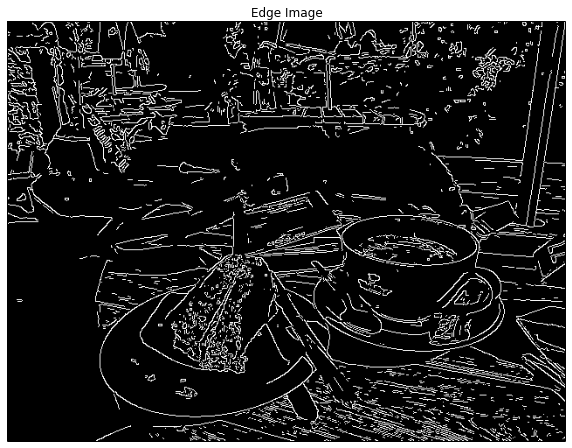

In [106]:
plt.figure(figsize=(10,10))
plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

In [107]:
# RETR_EXTERNAL: only want to extract only the outer contours
im2, contours, hierarchy = cv2.findContours(edges,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

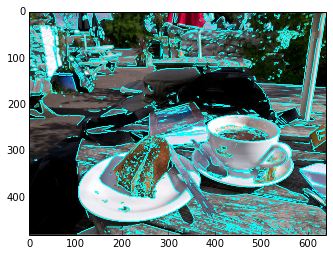

In [108]:
plotContour(img_name,contours)

w is the diagonal length of user's annotation box 


In [162]:
#testing an object (coffee cup) with a more connected Canny contour
oid = 10
obj = object_tbl[object_tbl["object_id"]==oid]
x_loc = int(obj["x_loc"])
y_loc = int(obj["y_loc"])
Ji = bb_info[bb_info["object_id"]==oid]
bb = Ji.ix[103]
bb_data = np.array([ast.literal_eval(bb["x_locs"]),ast.literal_eval(bb["y_locs"])])

In [163]:
from scipy.spatial import distance
def find_w(bb_data):
    allp2pDist = distance.pdist(bb_data.T)
    w = allp2pDist.max() #bounding box diameter = diagonal length of user BB
    return w

In [164]:
find_w(bb_data)

187.87761974221411

discard contours which are (1) shorter than 3% of w, because such contours tend to be texture not boundaries, (2) more than 5% of w away from the user
annotation, or (3) oriented more than 20 degrees away from the nearby user annotation. Finally, we find the boundary which has the most edge overlap and we assign a score to the user annotation in proportion to how much this best boundary was dilated or eroded.

In [165]:
#Filter out contours shorter than 3% of w 
length_filtered_contours = filter(lambda x: cv2.arcLength(x,False)>0.03*w,contours)

In [166]:
from shapely.geometry import Polygon, Point

In [167]:
# this user annotation box is the "standard" that we compare all our contours against
bb_standard = Polygon([list(a) for a in zip(bb_data[0],bb_data[1])])

In [168]:
i=0
c = length_filtered_contours[i][:,0]

In [169]:
# d2BB contains a list of boolean for each point in the contour specifying whether the point is within w away from the BB
d2BB = [Point(xyloc).distance(bb_standard)<w for xyloc in c]

In [170]:
dist_length_filtered_contours = []
for contour in length_filtered_contours:
    # d2BB contains a list of boolean for each point in the contour specifying whether the point is within w away from the BB
    d2BB = [Point(xyloc).distance(bb_standard)<0.05*w for xyloc in contour[:,0]]
    unique_elements = list(set(d2BB))
#     print unique_elements
    if len(unique_elements) ==1:
        if unique_elements[0]==True:
            #True only 
            dist_length_filtered_contours.append(contour)
    elif len(unique_elements) ==2:
        pass # contain at least one point that is more than w away from BB, so exclude this contour

In [171]:
print len(length_filtered_contours)
print len(dist_length_filtered_contours)

760
43


In [172]:
mpld3.disable_notebook()

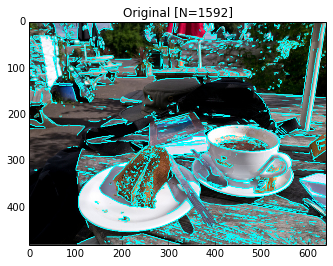

In [173]:
plotContour(img_name,contours,title="Original [N={}]".format(len(contours)))

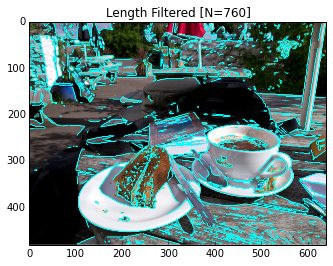

In [174]:
plotContour(img_name,length_filtered_contours,"Length Filtered [N={}]".format(len(length_filtered_contours)))

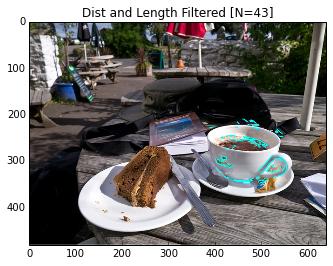

In [175]:
plotContour(img_name,dist_length_filtered_contours,"Dist and Length Filtered [N={}]".format(len(dist_length_filtered_contours)))

Not really sure how the last one applies. Will do the edge overlap first 

In [527]:
len(dist_length_filtered_contours)

64

Initially I think we should group together contours first 

In [67]:
import mpld3
mpld3.enable_notebook()

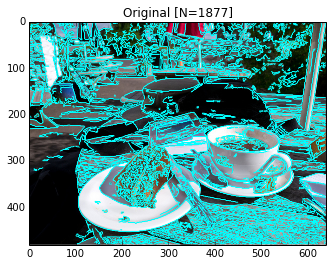

In [50]:
plotContour(img_name,contours,title="Original [N={}]".format(len(contours)))

Taking a closer look, I actually find that these are closed curved and they are not really lines

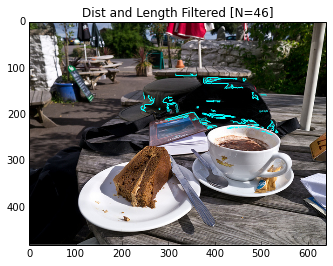

In [68]:
plotContour(img_name,dist_length_filtered_contours,"Dist and Length Filtered [N={}]".format(len(dist_length_filtered_contours)))

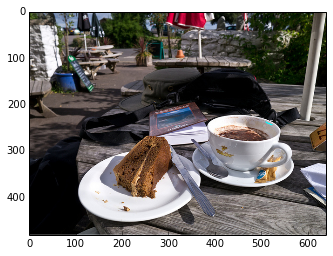

In [83]:
plotContour(img_name,[cnt])

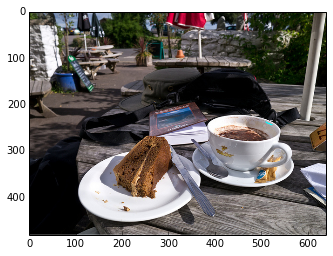

In [82]:
cnt =dist_length_filtered_contours[0]
plotContour(img_name,[cv2.approxPolyDP(cnt,epsilon=0.1,closed=True)])